In [40]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import nlp
import random
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer

In [42]:
import tensorflow as tf
import matplotlib
import numpy as np
import sklearn
import nlp

In [43]:
# Get TensorFlow version
print("TensorFlow version:", tf.__version__)

# Get nlp (Hugging Face's transformers library) version
print("nlp version:", nlp.__version__)

# Get Matplotlib version
print("Matplotlib version:", matplotlib.__version__)

# Get scikit-learn version
print("scikit-learn version:", sklearn.__version__)

# Get NumPy version
print("NumPy version:", np.__version__)

TensorFlow version: 2.17.0
nlp version: 0.4.0
Matplotlib version: 3.8.3
scikit-learn version: 1.4.1.post1
NumPy version: 1.26.4


In [2]:
def show_history(h):
    epochs_trained=len(h.history['loss'])
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training') 
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation') 
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [3]:
def show_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    im = sp.matshow(cm, cmap='Blues')  # Use cmap='Blues' for a clearer visualization
    plt.colorbar(im)
    plt.xticks(np.arange(len(classes)), labels=classes, rotation=45)
    plt.yticks(np.arange(len(classes)), labels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()
    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.0


# Task 3: Importing Data
1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [4]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion", "split")

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
train = dataset['train']
val = dataset['validation'] 
test = dataset['test']

In [8]:
label_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

def get_tweet(data):
    tweets = [x['text'] for x in data]
    labels = [label_names[x['label']] for x in data]
    return tweets, labels

In [9]:
tweets,labels = get_tweet(train)

In [10]:
tweets[4],labels[4]

('i am feeling grouchy', 'anger')

# Task 4: Tokenizer
1. Tokenizing the tweets

In [44]:
tokenizer = Tokenizer(num_words=1000,oov_token= '<UNK>') 
tokenizer.fit_on_texts(tweets)

In [12]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [13]:
tweets[4]

'i am feeling grouchy'

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer
import json

# Assuming `tokenizer` is your trained Tokenizer object
# Save tokenizer configuration to JSON
tokenizer_json = tokenizer.to_json()

# Write JSON to file
with open('tokenizer.json', 'w') as file:
    json.dump(tokenizer_json, file)

# Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

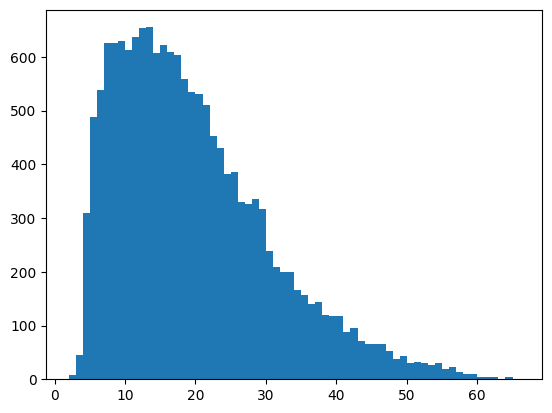

In [14]:
lengths=[len(t.split(' ')) for t in tweets] 
plt.hist (lengths, bins = len(set(lengths))) 
plt.show()

In [15]:
maxlen=50

from tensorflow.keras.preprocessing. sequence import pad_sequences

In [16]:
def get_sequences (tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen) 
    return padded

In [17]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [18]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

# Task 6: Preparing the Labels
1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [19]:
classes = set(labels)
print("Classes:", classes)

Classes: {'surprise', 'joy', 'anger', 'love', 'fear', 'sadness'}


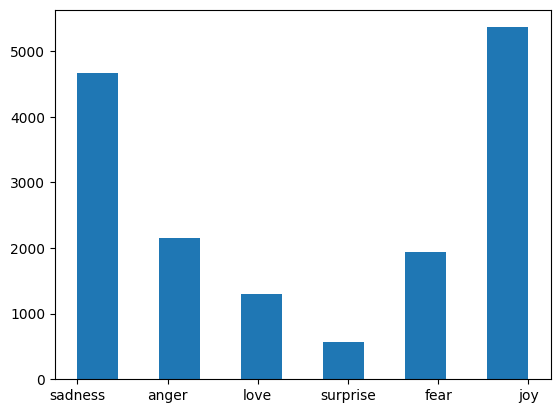

In [20]:
plt.hist(labels,bins=11)
plt.show()

In [21]:
class_to_index = {label: index for index, label in enumerate(label_names)}
index_to_class = {index: label for index, label in enumerate(label_names)}

In [22]:
print("class_to_index:", class_to_index)
print("index_to_class:", index_to_class)

class_to_index: {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}
index_to_class: {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


In [23]:
names_to_ids=lambda labels:np.array([class_to_index.get(x) for x in labels])

In [24]:
train_labels=names_to_ids(labels)
print(train_labels[4])

3


# Task 7: Creating the Model
1. Creating the model
2. Compiling the model

In [25]:
model_text = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(1000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_text.build(input_shape=(None, maxlen))

model_text.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)


C:\Users\projj\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [26]:
model_text.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 16)              │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 40)              │           5,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 40)                  │           9,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             246 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,926 (124.71 KB)

 Trainable params: 31,926 (124.71 KB)

 Non-trainable params: 0 (0.00 B)

# Task 8: Training the Model
1. Preparing a validation set
2. Training the model

In [27]:
val_tweets,val_labels = get_tweet(val) 
val_seq = get_sequences(tokenizer,val_tweets) 
val_labels = names_to_ids(val_labels)

In [28]:
val_tweets[1],val_labels[1]

('i feel like i am still looking at a blank canvas blank pieces of paper', 0)

In [29]:
h = model_text.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.3628 - loss: 1.5633 - val_accuracy: 0.5845 - val_loss: 1.0550
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.6985 - loss: 0.8389 - val_accuracy: 0.7430 - val_loss: 0.6945
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.7973 - loss: 0.5936 - val_accuracy: 0.8125 - val_loss: 0.5588
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.8385 - loss: 0.4746 - val_accuracy: 0.8300 - val_loss: 0.4967
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.8586 - loss: 0.4027 - val_accuracy: 0.8410 - val_loss: 0.4186
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.8796 - loss: 0.3324 - val_accuracy: 0.8575 - val_loss: 0.3939
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8895 - loss: 0.2993 - val_accuracy: 0.8565 - val_loss: 0.4071
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8925 - loss: 0.2814 - 

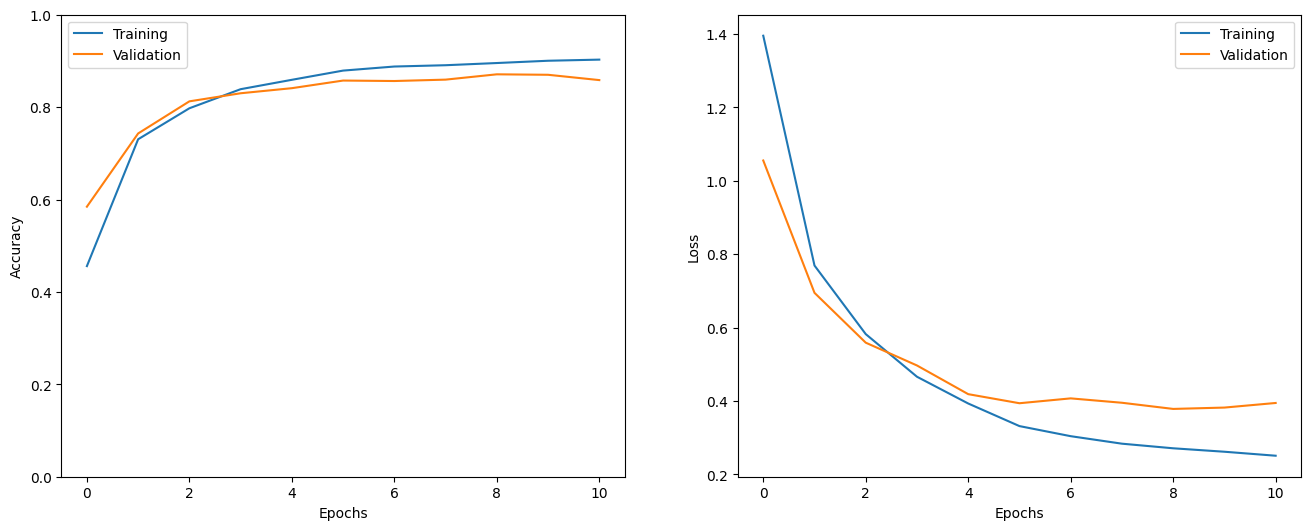

In [30]:
show_history(h)

In [31]:
test_tweets,test_labels=get_tweet(test) 
test_seq=get_sequences(tokenizer, test_tweets) 
test_labels=names_to_ids(test_labels)

In [32]:
_=model_text.evaluate(test_seq, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8592 - loss: 0.3728


In [33]:
i=random.randint(0, len(test_labels)-1) 
print('Sentence:', test_tweets[i])

print('Emotion:', index_to_class[test_labels[i]]) 
p=model_text.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')] 
print('Predicted Emotion:',pred_class)

Sentence: i feel uncomfortable here
Emotion: fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
Predicted Emotion: fear


In [34]:
preds=model_text.predict(test_seq)
classes_x=np.argmax(preds, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


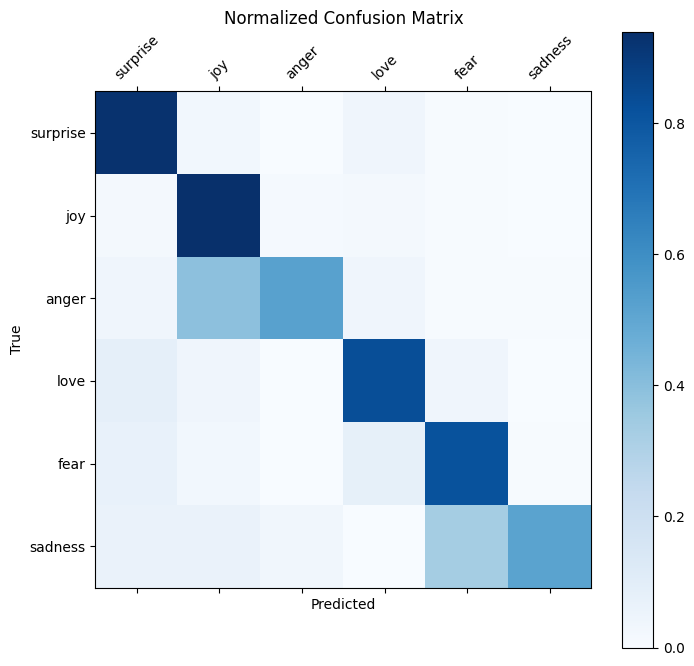

In [35]:
show_confusion_matrix(test_labels, classes_x, list(classes))

In [36]:
# Save the model weights in .h5 format
#from tensorflow.keras.models import load_model
#model_text.save("./model_text.h5")

In [38]:
import pickle

In [39]:
pickle.dump(model_text, open('model_text.pkl','wb'))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB  # Replace with another model if needed
import joblib

In [4]:
# Load dataset
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion", "split")

In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

label_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

def get_tweet(data):
    tweets = [x['text'] for x in data]
    labels = [label_names[x['label']] for x in data]
    return tweets, labels

In [6]:
# Get train and validation data
train_tweets, train_labels = get_tweet(train)
val_tweets, val_labels = get_tweet(val)

# Use TF-IDF vectorization instead of Tokenizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train = vectorizer.fit_transform(train_tweets).toarray()
X_val = vectorizer.transform(val_tweets).toarray()

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_val = label_encoder.transform(val_labels)

# Save vectorizer and label encoder
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

In [11]:
# Train a Naive Bayes model
model_text = MultinomialNB()
model_text.fit(X_train, y_train)

MultinomialNB()

In [12]:
# Evaluate model
accuracy = model_text.score(X_val, y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.8225


In [14]:
# Save the trained model
joblib.dump(model_text, "model_textNB.pkl")

['model_textNB.pkl']

In [9]:
# Function to predict emotion
def predict_text_emotion(text):
    text_vectorized = vectorizer.transform([text]).toarray()
    prediction = model_text.predict(text_vectorized)
    predicted_label = label_encoder.inverse_transform(prediction)[0]
    return predicted_label

# Example prediction
print(predict_text_emotion("I am very happy today!"))

joy
